<a href="https://colab.research.google.com/github/gemenerik/RTSR4k/blob/master/RTSR4k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>RTSR4k</h1>




Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent tincidunt pretium enim. Nunc fermentum malesuada nibh non scelerisque. Praesent et erat et ligula iaculis elementum vitae ac odio. Fusce feugiat mollis aliquam. Curabitur tristique dolor ut orci volutpat gravida. Nunc malesuada tempor mauris, eget posuere ante consectetur ac. Ut maximus justo nisi, ut eleifend odio posuere sed. Ut dolor urna, ullamcorper ut turpis sit amet, finibus ultricies massa. Sed sollicitudin nisl id libero ullamcorper suscipit.

Nullam auctor leo tellus, nec viverra massa malesuada quis. Nunc euismod nisl euismod, dignissim quam eu, lobortis mauris. Nunc efficitur facilisis viverra. Fusce at arcu non risus lacinia vestibulum. Nunc nec condimentum lorem. Pellentesque laoreet neque et metus luctus, ac finibus massa iaculis. Ut eu pulvinar ex, in dignissim ipsum. Etiam vitae lacinia felis. Praesent ornare dolor eget euismod sollicitudin.

### Pull from GitHub

In [39]:
!sudo rm -rf RTSR4k
!git clone https://github.com/gemenerik/RTSR4k

import os
os.chdir('RTSR4k/data')
os.mkdir('val')
os.chdir('..')

Cloning into 'RTSR4k'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 205 (delta 32), reused 71 (delta 15), pack-reused 112
Receiving objects: 100% (205/205), 18.51 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (40/40), done.


### Tweakable settings

In [0]:
UPSCALE_FACTOR = 3 #@param {type:"slider", min:1, max:5, step:1}
GAUSSIAN_BLUR_RADIUS = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

### Data processing 

In [42]:
import argparse
import os
from os import listdir
from os.path import join

from PIL import Image, ImageFilter
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, CenterCrop, Scale
from tqdm import tqdm


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.JPG', '.JPEG', '.PNG', '.bmp'])


def is_video_file(filename):
    return any(filename.endswith(extension) for extension in ['.mp4', '.avi', '.mpg', '.mkv', '.wmv', '.flv'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def blur(img):
    img2 = img.filter(ImageFilter.GaussianBlur(GAUSSIAN_BLUR_RADIUS))
    return img2


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Scale(crop_size // upscale_factor, interpolation=Image.BICUBIC), blur
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size)
    ])


class DatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_dir = dataset_dir + '/scaling_factor_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/scaling_factor_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, _, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        target, _, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)


def generate_dataset(data_type, upscale_factor, data_target):
    images_name = [x for x in listdir('data/' + data_type) if is_image_file(x)]
    crop_size = calculate_valid_crop_size(256, upscale_factor)
    lr_transform = input_transform(crop_size, upscale_factor)
    hr_transform = target_transform(crop_size)

    root = 'data/' + data_target
    if not os.path.exists(root):
        os.makedirs(root)
    path = root + '/scaling_factor_' + str(upscale_factor)
    if not os.path.exists(path):
        os.makedirs(path)
    image_path = path + '/data'
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    target_path = path + '/target'
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    for image_name in tqdm(images_name, desc='generate ' + data_type + ' dataset with upscale factor = '
            + str(upscale_factor) + ' from dataset'):
        image = Image.open('data/' + data_type + '/' + image_name)
        target = image.copy()
        image = lr_transform(image)
        target = hr_transform(target)

        image.save(image_path + '/' + image_name)
        target.save(target_path + '/' + image_name)


if __name__ == "__main__":
    generate_dataset(data_type='original_data/train', upscale_factor=UPSCALE_FACTOR, data_target='train')
    generate_dataset(data_type='original_data/test/Set14', upscale_factor=UPSCALE_FACTOR, data_target='test')
    generate_dataset(data_type='val', upscale_factor=UPSCALE_FACTOR, data_target='val')

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
generate original_data/train dataset with upscale factor = 3 from dataset: 100%|██████████| 91/91 [00:00<00:00, 514.42it/s]
generate original_data/test/Set14 dataset with upscale factor = 3 from dataset: 100%|██████████| 14/14 [00:00<00:00, 34.40it/s]
generate val dataset with upscale factor = 3 from dataset: 0it [00:00, ?it/s]


### Train

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
Running on cuda


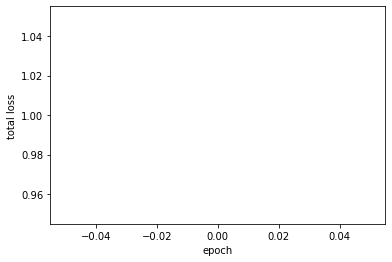

[1,    23] total loss: 1.182
lr: [0.01]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.


[2,    23] total loss: 0.213
lr: [0.01]
[3,    23] total loss: 0.136
lr: [0.01]
[4,    23] total loss: 0.112
lr: [0.01]
[5,    23] total loss: 0.096
lr: [0.01]
[6,    23] total loss: 0.087
lr: [0.01]
[7,    23] total loss: 0.112
lr: [0.01]
[8,    23] total loss: 0.159
lr: [0.01]
[9,    23] total loss: 0.152
lr: [0.01]
[10,    23] total loss: 0.109
lr: [0.0025]
[11,    23] total loss: 0.070
lr: [0.005]


In [0]:
from model import Net
from torchvision import transforms
from data_utils import DatasetFromFolder
import torch
import torch.nn as nn
import torch.optim
import pylab
import matplotlib.pyplot as plt




if __name__ == "__main__":
    net = Net(upscale_factor=UPSCALE_FACTOR)
    print(net)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running on', device)
    if device == 'cuda':
        net.cuda()
    transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
    ])
    
    # trainset = torchvision.datasets.ImageFolder(root = './data/train/SRF_3', transform=transforms.ToTensor(),
    #                                  target_transform=None)
    
    trainset = DatasetFromFolder('data/train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
    
    testset = DatasetFromFolder('data/val', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
    
    # testset = torchvision.datasets.ImageFolder(root = './data/val/SRF_3', transform=transform,
    #                                  target_transform=None)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)





    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=10e-3)

    " train net "
    epochs = []
    losses = []
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel('total loss')
    ax.set_xlabel('epoch')
    Ln, = ax.plot([0],[1])
    pylab.show()

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(30):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        print('[%d, %5d] total loss: %.3f' %
              (epoch + 1, i + 1, running_loss,))
        epochs.append(epoch+1)
        losses.append(running_loss)
        Ln.set_ydata(losses)
        Ln.set_xdata(epochs)
        ax.set_xlim(1,epoch+1)
        ax.set_ylim(0,max(losses))
        fig.canvas.draw()
        plt.show()
        plt.pause(0.1)
        
        running_loss = 0.0

        scheduler.step()
        print('lr: ' + str(scheduler.get_lr()))



    print('Finished Training')
    " save "
    PATH = './Trained.pth'
    torch.save(net.state_dict(), PATH)

### Test image

In [43]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision.transforms import ToTensor

from model import Net

from torchvision import transforms
from data_utils import DatasetFromFolder

trainset = DatasetFromFolder('data/train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

" load net "
PATH = 'Trained.pth'
net = Net(UPSCALE_FACTOR)
net.load_state_dict(torch.load(PATH))

i = UPSCALE_FACTOR
path = 'data/test/scaling_factor_%s/' %i
print(path)
image_name = 'baboon.png'


img = Image.open(path + '/data/' + image_name).convert('YCbCr')
y, cb, cr = img.split()
image = Variable(ToTensor()(y)).view(1, -1, y.size[1], y.size[0])

inputs, target = next(iter(trainloader))
pic = inputs.numpy()
output = net(inputs)


out = net(image)
out_img_y = out.data[0].numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
super_res_image = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
super_res_image.save('test.jpg')

low_res_image = Image.open(path + 'data/' + image_name)
display(low_res_image)
display(super_res_image)
high_res_image = Image.open(path + 'target/' + image_name)
display(high_res_image)

FileNotFoundError: ignored

##### PSNR

In [38]:
from numpy import mean
from math import log10, sqrt
from cv2 import imread
original = imread(path + 'target/' + image_name)
contrast = imread('test.jpg',1)
def psnr(img1, img2):
    mse = mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * log10(PIXEL_MAX / sqrt(mse))

d=psnr(original,contrast)
print(d)

34.423016816177594
